# Interpolate and average recombination rate and genetic map for superpopulations

In [41]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import gzip
import os

# Define the superpopulations
superpopulations = {
    "EUR": ["CEU", "IBS", "FIN", "GBR", "TSI"],
    "EAS": ["CDX", "CHB", "CHS", "JPT", "KHV"],
    "AFR": ["ACB", "ASW", "ESN", "GWD", "LWK", "MSL", "YRI"],
}

# A function to read the data
def read_data(filename):
    with gzip.open(filename, 'rt') as f:
        return pd.read_csv(f, delim_whitespace=True)

# A function to perform linear interpolation
def interpolate(subpop_data, full_positions):
    interp_rate = interp1d(subpop_data['Position(bp)'], subpop_data['Rate(cM/Mb)'], fill_value="extrapolate")
    interp_map = interp1d(subpop_data['Position(bp)'], subpop_data['Map(cM)'], fill_value="extrapolate")
    return interp_rate(full_positions), interp_map(full_positions)

dir_map = {"EUR": "/pollard/home/yorkz/york/BMI206/Sub_map/_EUR/", 
           "EAS": "/pollard/home/yorkz/york/BMI206/Sub_map/_EAS/",
           "AFR": "/pollard/home/yorkz/york/BMI206/Sub_map/_AFR/"}
# Process each superpopulation and chromosome
for superpop, subpops in superpopulations.items():
    print(superpop)
    # if superpop == "EUR" or superpop == "AFR":
    #     continue
    for chr_num in range(1, 23):
        print(chr_num)
        # Initialize an empty dataframe for the superpopulation
        superpop_data = pd.DataFrame(columns=['Position(bp)', 'Rate(cM/Mb)', 'Map(cM)'])
        
        for subpop in subpops:
            # print(subpop)
            # Read the data for the subpopulation and chromosome
            path = dir_map[superpop] + subpop + "/"
            filename = f"{path}{subpop}-{chr_num}-final.txt.gz"
            if os.path.exists(filename):
                try:
                    subpop_data = read_data(filename)
                except:
                    print(subpop)
                # Merge positions
                superpop_data = superpop_data.merge(subpop_data, on='Position(bp)', how='outer', suffixes=('', f'_{subpop}')).sort_values(by='Position(bp)')
                
        
        # Interpolate missing values
        full_positions = superpop_data['Position(bp)'].unique()
    #     break
    # break
        for subpop in subpops:
            if f'Rate(cM/Mb)_{subpop}' not in superpop_data:
                rate, map = interpolate(subpop_data, full_positions)
                superpop_data[f'Rate(cM/Mb)_{subpop}'] = rate
                superpop_data[f'Map(cM)_{subpop}'] = map
        
        # Calculate the average rate and map across subpopulations
        rate_columns = [col for col in superpop_data.columns if 'Rate(cM/Mb)' in col]
        map_columns = [col for col in superpop_data.columns if 'Map(cM)' in col]
        superpop_data['Average Rate(cM/Mb)'] = superpop_data[rate_columns].mean(axis=1)
        superpop_data['Average Map(cM)'] = superpop_data[map_columns].mean(axis=1)
        
        # Select and rename columns for the output
        superpop_data_final = superpop_data[['Position(bp)', 'Average Rate(cM/Mb)', 'Average Map(cM)']]
        
        # Write to file
        output_path = dir_map[superpop]
        output_filename = f"{output_path}{superpop}-{chr_num}-superpop-final.txt.gz"
        with gzip.open(output_filename, 'wt') as f:
            superpop_data_final.to_csv(f, index=False, sep='\t')
    # break
print("Merging complete.")


EUR
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
EAS
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
AFR
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
Merging complete.


# Select subset SNPs based on MAF > 1% in at least one of EUR, EAS, and AFR

In [27]:
tmp = "0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0"

In [28]:
def testFormat(haps):
    haps = [int(i) for i in haps.split()]
    assert not len(haps) % 2, "Should be even number of haplotypes"
    maf_c = sum(haps)
    return maf_c / len(haps)

In [1]:
# testFormat(tmp)
1

1

# Simulate phenotypes

In [133]:
np.corrcoef([1, 2, 3, 4, 5], [4.48617051766051,
 5.090847099100193,
 1.7333627448375761,
 2.7298777787003945,
 2.856700991798282])

array([[ 1.        , -0.64641397],
       [-0.64641397,  1.        ]])

In [10]:
import numpy as np
def simulate_shared_causal_variants(num_variants, correlation=0.7):
    """
    Simulate the per-allele effect sizes of causal variants shared across three populations.

    Parameters:
    num_variants (int): The number of causal variants to simulate.
    correlation (float): The correlation between the effect sizes in different populations.
    
    Returns:
    np.array: An array of shape (num_variants, 3) with the simulated effect sizes.
    """

    # The mean effect size for each variant in each population is assumed to be 0
    mean = np.zeros(3)

    # The covariance matrix reflects that all populations have the same variance
    # and the off-diagonal values are the covariance between populations
    covariance_matrix = np.full((3, 3), correlation)
    np.fill_diagonal(covariance_matrix, 1)

    # Simulate the effect sizes using a multivariate normal distribution
    simulated_effect_sizes = np.random.multivariate_normal(mean, covariance_matrix, size=num_variants)

    return simulated_effect_sizes

# Extract the actual correlations for the population pairs from the correlation matrix
# Note: The diagonal of the correlation matrix is always 1, since it's the correlation of each population with itself.
# We are interested in the off-diagonal elements which represent the correlation between different populations.

# # Correlation between population 1 and 2
# correlation_12 = correlation_matrix[0, 1]

# # Correlation between population 1 and 3
# correlation_13 = correlation_matrix[0, 2]

# # Correlation between population 2 and 3
# correlation_23 = correlation_matrix[1, 2]

# correlation_12, correlation_13, correlation_23

def simulate_phenotypes(effect_sizes, genotypes, heritability=0.5):
    """
    Simulate phenotypes for individuals in a population based on effect sizes, genotypes,
    and a specified heritability.

    Parameters:
    effect_sizes (np.array): The array of effect sizes for each variant (num_variants, num_populations).
    genotypes (np.array): The genotype matrix for individuals (num_individuals, num_variants).
    heritability (float): The heritability proportion of the phenotypic variance.

    Returns:
    np.array: An array of simulated phenotypes for each individual.
    """

    # Calculate the genetic contribution to the phenotype
    genetic_contribution = genotypes.dot(effect_sizes)

    # Calculate the total phenotypic variance based on the genetic variance and heritability
    genetic_variance = np.var(genetic_contribution, axis=0)
    phenotypic_variance = genetic_variance / heritability

    # Calculate the environmental variance which is the remaining variance to reach the total phenotypic variance
    environmental_variance = phenotypic_variance - genetic_variance

    # Generate the random environmental contribution for each individual
    environmental_contribution = np.random.normal(0, np.sqrt(environmental_variance), size=genetic_contribution.shape)

    # The phenotype is the sum of the genetic and environmental contributions
    phenotypes = genetic_contribution + environmental_contribution

    return phenotypes

# Generate genotypes for 100 individuals
num_individuals = 100
num_variants = 100
correlation = 0.7
heritability = 0.5
genotypes = np.random.randint(0, 3, size=(num_individuals, num_variants))  # Random genotypes with 0, 1, or 2 alleles
simulated_effect_sizes = simulate_shared_causal_variants(num_variants, correlation = 0.7)
# Calculate the pairwise correlations between the simulated effect sizes for each population pair
# correlation_matrix = np.corrcoef(simulated_effect_sizes, rowvar=False)

# Simulate phenotypes for each population using the effect sizes
# Assuming the same genotype for simplicity; in reality, genotypes would differ between populations
phenotypes_population_1 = simulate_phenotypes(simulated_effect_sizes[:, 0], genotypes, heritability)
phenotypes_population_2 = simulate_phenotypes(simulated_effect_sizes[:, 1], genotypes, heritability)
phenotypes_population_3 = simulate_phenotypes(simulated_effect_sizes[:, 2], genotypes, heritability)

phenotypes_population_1[:5], phenotypes_population_2[:5], phenotypes_population_3[:5]  # Show first 5 for brevity


(array([  2.34455267, -14.12529611,   5.31226278,   1.63081681,
          9.59350864]),
 array([-4.13288967, -5.1018043 ,  2.48249749,  5.571811  ,  2.96814068]),
 array([-14.01355694, -11.43999243,  -4.81235306, -24.07726664,
         -4.36636219]))

In [11]:
def calculate_heritability(phenotypes, genetic_contribution):
    """
    Calculate the heritability from the phenotypes and genetic contribution of individuals in a population.

    Parameters:
    phenotypes (np.array): The array of phenotypes for each individual.
    genetic_contribution (np.array): The genetic contribution to the phenotypes for each individual.

    Returns:
    float: The heritability estimate.
    """
    # Calculate the variance of the phenotypes and the genetic contribution
    phenotypic_variance = np.var(phenotypes, axis=0)
    genetic_variance = np.var(genetic_contribution, axis=0)

    # Heritability is the proportion of phenotypic variance that is due to genetic variance
    heritability_estimate = genetic_variance / phenotypic_variance

    return heritability_estimate

# correlation_matrix = np.corrcoef(simulated_effect_sizes, rowvar=False)
# print(correlation_matrix[0, 1], correlation_matrix[0, 2], correlation_matrix[1, 2])

# # Calculate the actual heritability for each population
# heritability_population_1 = calculate_heritability(phenotypes_population_1, genotypes.dot(simulated_effect_sizes[:, 0]))
# heritability_population_2 = calculate_heritability(phenotypes_population_2, genotypes.dot(simulated_effect_sizes[:, 1]))
# heritability_population_3 = calculate_heritability(phenotypes_population_3, genotypes.dot(simulated_effect_sizes[:, 2]))

# heritability_population_1, heritability_population_2, heritability_population_3


In [12]:
import gzip
import pandas as pd
import random

def read_snp_positions(file_name):
    """
    Read SNP positions from a .legend.gz file and return a list of tuples with chromosome and position.

    Parameters:
    file_name (str): The file path of the .legend.gz file.

    Returns:
    list of tuples: A list where each tuple contains the chromosome and the SNP position.
    """
    # Read the contents of the gzipped legend file
    with gzip.open(file_name, 'rt') as file:
        # Use pandas to read the tab-separated values
        df = pd.read_csv(file, sep=" ")  # Skip the header row

    # Extract chromosome number from the file name
    chromosome = file_name.split('_')[-2].split("/")[-1]

    # Create a list of tuples (chromosome, position)
    snp_positions = [(chromosome, pos) for pos in range(len(df['position']))]

    return snp_positions

# Assuming we have file paths like "chr1_hapmap3.legend.gz", "chr2_hapmap3.legend.gz", ..., "chr22_hapmap3.legend.gz"
file_paths = [f"/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr{chromosome}_hapmap3.legend.gz" for chromosome in range(1, 23)]

# Read in all SNP positions for each chromosome file
all_snps = []
for file_path in file_paths:
    print(file_path)
    all_snps.extend(read_snp_positions(file_path))



/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr1_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr2_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr3_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr4_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr5_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr6_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr7_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr8_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr9_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr10_hapmap3.legend.gz
/pollard/home/yorkz/york/BMI206/1000GP_Phase3/Subset/Intersect_HM/chr11_hapmap3.legend.gz
/pollard/home/yorkz

In [17]:
# Randomly select 1% of the SNPs to be causal
num_causal_snps = int(len(all_snps) * 0.01)
causal_snps = random.sample(all_snps, num_causal_snps)

# The list causal_snps now contains the randomly selected SNPs as (chromosome, position) tuples
causal_snps[:10]  # Show first 10 for brevity

f = open("/pollard/home/yorkz/york/BMI206/causal_snps.txt", "w")
for i in causal_snps:
    f.write(i[0])
    f.write(" ")
    f.write(str(i[1]))
    f.write("\n")
f.close()

In [11]:
genotypes = np.random.randint(0, 3, size=(num_individuals, 10))

In [47]:
genotypes

array([[0, 1, 0, 2, 2, 0, 1, 2, 2, 1],
       [0, 2, 2, 2, 0, 2, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 2, 0, 0, 1, 2],
       [1, 2, 1, 1, 1, 2, 1, 2, 2, 1],
       [1, 0, 0, 2, 0, 2, 2, 1, 2, 0],
       [2, 1, 0, 2, 2, 0, 0, 0, 2, 2],
       [1, 0, 1, 2, 0, 2, 0, 0, 0, 2],
       [1, 0, 2, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 2, 2, 0, 2, 1, 0, 1],
       [1, 2, 2, 1, 0, 1, 2, 2, 0, 0],
       [2, 0, 0, 0, 2, 1, 0, 2, 1, 2],
       [2, 1, 2, 2, 1, 1, 0, 2, 1, 0],
       [2, 0, 2, 2, 2, 2, 0, 2, 2, 2],
       [1, 2, 2, 0, 2, 0, 2, 0, 0, 0],
       [0, 1, 1, 0, 0, 2, 1, 1, 2, 1],
       [2, 1, 2, 0, 0, 1, 0, 2, 0, 2],
       [0, 0, 2, 2, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 0, 1, 2, 1, 1, 2, 2],
       [2, 2, 1, 1, 0, 2, 0, 1, 2, 0],
       [0, 0, 2, 2, 0, 0, 2, 1, 2, 1],
       [0, 0, 1, 0, 2, 0, 1, 2, 2, 2],
       [1, 1, 0, 1, 2, 1, 0, 2, 0, 0],
       [1, 1, 0, 2, 1, 2, 2, 0, 2, 0],
       [0, 2, 1, 2, 1, 0, 2, 2, 1, 0],
       [2, 0, 2, 1, 0, 0, 1, 2, 1, 1],
       [2, 0, 1, 0, 0, 0,

In [13]:
def read_genotype_file(filename):
    with open(filename, 'r') as file:
        # Read all lines and split each line into a list of values
        data = [line.strip().split() for line in file]
    print(0)
    # Remove the first two columns (chromosome number and position)
    # info_data = [row[:5] for row in data]
    genotype_data = [row[5:] for row in data]
    print(1)
    # Transpose the data to make rows as individuals and columns as SNPs
    genotype_array = np.array(genotype_data, dtype=int).T

    return genotype_array

# Example usage
filename = '/pollard/home/yorkz/york/BMI206/Simulated_pop/Causal/001/AFR_causal_snp_genotypes.txt'
genotype_AFR = read_genotype_file(filename)
# filename = '/pollard/home/yorkz/york/BMI206/Simulated_pop/Causal/001/EAS_causal_snp_genotypes.txt'
# genotype_EAS = read_genotype_file(filename)
filename = '/pollard/home/yorkz/york/BMI206/Simulated_pop/Causal/001/EUR_causal_snp_genotypes.txt'
genotype_EUR = read_genotype_file(filename)

0
1
0
1


In [15]:
import pandas as pd
# EAS_sample = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/EAS.controls.sample", sep = " ")
EUR_sample = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/EUR.controls.sample", sep = " ")
AFR_sample = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/AFR.controls.sample", sep = " ")

/tmp/ipykernel_122359/1589072423.py:3: DtypeWarning: Columns (3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  EUR_sample = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/EUR.controls.sample", sep = " ")
/tmp/ipykernel_122359/1589072423.py:4: DtypeWarning: Columns (3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  AFR_sample = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/AFR.controls.sample", sep = " ")


In [18]:
EUR_sample

,ID_1,ID_2,missing,pheno,pheno_h0.005,pheno_h0.05,pheno_c0.1,pheno_c0.4
0,0,0,0,P,P,P,P,P
1,id1_0,id2_0,0,46.131422403016856,-184.69776881057044,-13.023803406714535,268.5115357101723,-24.790307590065236
2,id1_1,id2_1,0,-28.358992529484688,-948.4599589443067,-264.15577433970935,134.78686176588786,-88.57698489236226
3,id1_2,id2_2,0,185.61612584983482,-79.482090184545,117.67868367095492,292.10301473783596,109.85607454811964
4,id1_3,id2_3,0,-58.53234710908761,-993.8594073607894,-298.23116147587643,-38.43474768228714,-84.36539867046763
...,...,...,...,...,...,...,...,...
199996,id1_199995,id2_199995,0,-20.08714,-816.786976,-224.259578,121.873764,-72.475612
199997,id1_199996,id2_199996,0,98.361176,-283.384951,0.530056,211.998828,37.739267
199998,id1_199997,id2_199997,0,138.217818,398.028964,204.800328,233.196968,87.39215
199999,id1_199998,id2_199998,0,23.542024,161.88663,58.995973,220.353264,-31.342096


In [19]:
AFR_sample = AFR_sample[["ID_1", "ID_2", "missing"]]
EUR_sample = EUR_sample[["ID_1", "ID_2", "missing"]]

,ID_1,ID_2,missing
0,0,0,0
1,id1_0,id2_0,0
2,id1_1,id2_1,0
3,id1_2,id2_2,0
4,id1_3,id2_3,0
...,...,...,...
199996,id1_199995,id2_199995,0
199997,id1_199996,id2_199996,0
199998,id1_199997,id2_199997,0
199999,id1_199998,id2_199998,0


In [23]:
num_variants = 13382
# for heritability in [0.005, 0.05]:
#     np.random.seed(1729)
#     correlation = 0.7
#     simulated_effect_sizes = simulate_shared_causal_variants(num_variants, correlation)
#     print(0)
#     phenos_AFR = simulate_phenotypes(simulated_effect_sizes[:, 0], genotype_AFR, heritability)
#     print(1)
#     phenos_EAS = simulate_phenotypes(simulated_effect_sizes[:, 1], genotype_EAS, heritability)
#     print(2)
#     phenos_EUR = simulate_phenotypes(simulated_effect_sizes[:, 2], genotype_EUR, heritability)
#     AFR_sample["pheno_h" + str(heritability)] = ["P"] + list(phenos_AFR)
#     EAS_sample["pheno_h" + str(heritability)] = ["P"] + list(phenos_EAS)
#     EUR_sample["pheno_h" + str(heritability)] = ["P"] + list(phenos_EUR)

# for correlation in [0.1, 0.4]:
#     np.random.seed(1729)
#     heritability = 0.5
#     simulated_effect_sizes = simulate_shared_causal_variants(num_variants, correlation)
#     print(0)
#     phenos_AFR = simulate_phenotypes(simulated_effect_sizes[:, 0], genotype_AFR, heritability)
#     print(1)
#     phenos_EAS = simulate_phenotypes(simulated_effect_sizes[:, 1], genotype_EAS, heritability)
#     print(2)
#     phenos_EUR = simulate_phenotypes(simulated_effect_sizes[:, 2], genotype_EUR, heritability)
#     AFR_sample["pheno_c" + str(correlation)] = ["P"] + list(phenos_AFR)
#     EAS_sample["pheno_c" + str(correlation)] = ["P"] + list(phenos_EAS)
#     EUR_sample["pheno_c" + str(correlation)] = ["P"] + list(phenos_EUR)
np.random.seed(1729)
for i in range(20):
    heritability = 0.5
    correlation = 0.7
    simulated_effect_sizes = simulate_shared_causal_variants(num_variants, correlation)
    print(0)
    phenos_AFR = simulate_phenotypes(simulated_effect_sizes[:, 0], genotype_AFR, heritability)
    print(1)
    # phenos_EAS = simulate_phenotypes(simulated_effect_sizes[:, 1], genotype_EAS, heritability)
    # print(2)
    phenos_EUR = simulate_phenotypes(simulated_effect_sizes[:, 2], genotype_EUR, heritability)
    AFR_sample["pheno" + str(i)] = ["P"] + list(phenos_AFR)
    # EAS_sample["pheno" + str(i)] = ["P"] + list(phenos_EAS)
    EUR_sample["pheno" + str(i)] = ["P"] + list(phenos_EUR)

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [26]:
EUR_sample

,ID_1,ID_2,missing,pheno0,pheno1,pheno2,pheno3,pheno4,pheno5,pheno6,...,pheno10,pheno11,pheno12,pheno13,pheno14,pheno15,pheno16,pheno17,pheno18,pheno19
0,0,0,0,P,P,P,P,P,P,P,...,P,P,P,P,P,P,P,P,P,P
1,id1_0,id2_0,0,132.724554,28.0506,-20.534323,-291.247006,-34.940853,-89.881874,-29.694993,...,-74.302355,178.729886,-311.534643,115.178334,-146.93665,-69.855536,88.443926,-120.91894,25.452154,180.232795
2,id1_1,id2_1,0,94.433548,51.28774,13.600457,-26.276287,82.417802,-36.627841,-45.031329,...,-96.042793,24.520882,-116.575246,254.501987,2.971607,-48.015045,11.952342,-151.746678,68.751674,222.231416
3,id1_2,id2_2,0,283.808061,183.589212,-162.592264,-118.326538,22.815905,-44.320069,-79.198721,...,-33.21446,187.677861,-211.679151,206.784624,-7.486483,-82.909325,101.679086,67.588355,181.07762,99.869998
4,id1_3,id2_3,0,-10.214896,-98.269143,8.041041,14.291318,46.361613,33.295226,-73.773045,...,42.823511,92.875154,-214.235973,235.91894,6.666502,71.556082,-37.461864,107.939094,104.414582,178.650128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199996,id1_199995,id2_199995,0,158.868965,-120.590873,-40.0036,-40.961261,-2.663888,-187.723092,-71.654989,...,16.845934,54.883681,-156.526616,200.785784,-60.817667,-139.104663,26.020654,60.258131,89.470432,111.255732
199997,id1_199996,id2_199996,0,92.491028,25.249723,102.689816,-71.441059,-75.203966,-65.317761,-124.352035,...,111.595098,73.924239,-184.164828,198.190307,15.191551,-160.268406,33.364593,28.351555,127.88021,112.236148
199998,id1_199997,id2_199997,0,65.856087,143.320472,29.494813,-39.421235,9.098789,37.710563,45.736092,...,49.668028,74.61992,-57.037958,162.157484,3.643527,-102.032979,-59.253078,-2.108986,-4.82495,150.543699
199999,id1_199998,id2_199998,0,69.463319,82.927072,-85.019865,-169.227038,136.511714,-224.687549,-114.430655,...,-43.678792,-25.651888,-374.697992,258.802719,69.978608,-224.721448,-99.591436,93.948425,80.202801,127.293424


In [27]:
EUR_sample.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/EUR.controls.sample", index = False, sep = " ")
# EAS_sample.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/EAS.controls.sample", index = False, sep = " ")
AFR_sample.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/AFR.controls.sample", index = False, sep = " ")

In [28]:
target_dir = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/"
# EAS_target = pd.read_csv(target_dir + "EAS.target.sample", sep = " ")
AFR_target = pd.read_csv(target_dir + "AFR.target.sample", sep = " ")
EUR_target = pd.read_csv(target_dir + "EUR.target.sample", sep = " ")

In [30]:
# EUR_target
# pd.merge(EAS_target, EAS_sample, on = "ID_1", how = "inner", )
# EAS_target = EAS_sample[EAS_sample["ID_1"].isin(EAS_target["ID_1"])]
AFR_target = AFR_sample[AFR_sample["ID_1"].isin(AFR_target["ID_1"])]
EUR_target = EUR_sample[EUR_sample["ID_1"].isin(EUR_target["ID_1"])]

In [32]:
EUR_target.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/EUR.target.sample", index = False, sep = " ")
# EAS_target.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/EAS.target.sample", index = False, sep = " ")
AFR_target.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/AFR.target.sample", index = False, sep = " ")

In [34]:
discovery_dir = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/"
# EAS_discovery = pd.read_csv(discovery_dir + "EAS_20000.discovery.sample", sep = " ")
AFR_discovery = pd.read_csv(discovery_dir + "AFR.discovery.sample", sep = " ")
EUR_discovery = pd.read_csv(discovery_dir + "EUR.discovery.sample", sep = " ")

/tmp/ipykernel_122359/3986168603.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  EUR_discovery = pd.read_csv(discovery_dir + "EUR.discovery.sample", sep = " ")


In [36]:
# EAS_discovery = EAS_sample[EAS_sample["ID_1"].isin(EAS_discovery["ID_1"])]
AFR_discovery = AFR_sample[AFR_sample["ID_1"].isin(AFR_discovery["ID_1"])]
EUR_discovery = EUR_sample[EUR_sample["ID_1"].isin(EUR_discovery["ID_1"])]

In [38]:
EUR_discovery.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/EUR.discovery.sample", index = False, sep = " ")
# EAS_discovery.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Discovery_sub/EAS_20000.discovery.sample", index = False, sep = " ")
AFR_discovery.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/AFR.discovery.sample", index = False, sep = " ")

In [41]:
EUR_discovery

,ID_1,ID_2,missing,pheno0,pheno1,pheno2,pheno3,pheno4,pheno5,pheno6,...,pheno10,pheno11,pheno12,pheno13,pheno14,pheno15,pheno16,pheno17,pheno18,pheno19
0,0,0,0,P,P,P,P,P,P,P,...,P,P,P,P,P,P,P,P,P,P
1,id1_0,id2_0,0,132.724554,28.0506,-20.534323,-291.247006,-34.940853,-89.881874,-29.694993,...,-74.302355,178.729886,-311.534643,115.178334,-146.93665,-69.855536,88.443926,-120.91894,25.452154,180.232795
2,id1_1,id2_1,0,94.433548,51.28774,13.600457,-26.276287,82.417802,-36.627841,-45.031329,...,-96.042793,24.520882,-116.575246,254.501987,2.971607,-48.015045,11.952342,-151.746678,68.751674,222.231416
3,id1_2,id2_2,0,283.808061,183.589212,-162.592264,-118.326538,22.815905,-44.320069,-79.198721,...,-33.21446,187.677861,-211.679151,206.784624,-7.486483,-82.909325,101.679086,67.588355,181.07762,99.869998
4,id1_3,id2_3,0,-10.214896,-98.269143,8.041041,14.291318,46.361613,33.295226,-73.773045,...,42.823511,92.875154,-214.235973,235.91894,6.666502,71.556082,-37.461864,107.939094,104.414582,178.650128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199996,id1_199995,id2_199995,0,158.868965,-120.590873,-40.0036,-40.961261,-2.663888,-187.723092,-71.654989,...,16.845934,54.883681,-156.526616,200.785784,-60.817667,-139.104663,26.020654,60.258131,89.470432,111.255732
199997,id1_199996,id2_199996,0,92.491028,25.249723,102.689816,-71.441059,-75.203966,-65.317761,-124.352035,...,111.595098,73.924239,-184.164828,198.190307,15.191551,-160.268406,33.364593,28.351555,127.88021,112.236148
199998,id1_199997,id2_199997,0,65.856087,143.320472,29.494813,-39.421235,9.098789,37.710563,45.736092,...,49.668028,74.61992,-57.037958,162.157484,3.643527,-102.032979,-59.253078,-2.108986,-4.82495,150.543699
199999,id1_199998,id2_199998,0,69.463319,82.927072,-85.019865,-169.227038,136.511714,-224.687549,-114.430655,...,-43.678792,-25.651888,-374.697992,258.802719,69.978608,-224.721448,-99.591436,93.948425,80.202801,127.293424


In [58]:
np.random.seed(1729)
num_variants = 13382
correlation = 0.7
heritability = 0.5
simulated_effect_sizes = simulate_shared_causal_variants(num_variants, correlation)




(13382, 3)

In [63]:
# AFR_pop = simulate_phenotypes(simulated_effect_sizes[:, 0], genotype_AFR, heritability)
EAS_pop = simulate_phenotypes(simulated_effect_sizes[:, 1], genotype_EAS, heritability)
# EUR_pop = simulate_phenotypes(simulated_effect_sizes[:, 2], genotype_EUR, heritability)


In [64]:
heritability_EAS = calculate_heritability(EAS_pop, genotype_EAS.dot(simulated_effect_sizes[:, 1]))

In [74]:
genotype_EAS

array([[0, 2, 0, ..., 0, 2, 0],
       [0, 2, 0, ..., 0, 2, 0],
       [0, 1, 0, ..., 0, 2, 0],
       ...,
       [0, 2, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 2, 0, ..., 0, 0, 1]])

In [74]:
import os
import pandas as pd

In [119]:
del genotype_AFR

In [102]:
tmp = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/tmp.sample", sep = " ")
# tmp["pheno"] = np.append("P", AFR_pop)
# tmp.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/tmp.sample", index = False, sep = " ")

,ID_1,ID_2,missing,pheno
0,0,0,0,B
1,id1_0,id2_0,0,0
2,id1_1,id2_1,0,0
3,id1_2,id2_2,0,0
4,id1_3,id2_3,0,0
...,...,...,...,...
99996,id1_99995,id2_99995,0,0
99997,id1_99996,id2_99996,0,0
99998,id1_99997,id2_99997,0,0
99999,id1_99998,id2_99998,0,0


In [124]:
len(EUR_pop)

200000

In [123]:
p = "EUR"
pheno_map = {"EUR": EUR_pop}

prefix = "/pollard/home/yorkz/york/BMI206/Simulated_pop/"
for file in os.listdir(prefix):
    if ".controls.sample" in file and p in file:
        print(file)
        tmp = pd.read_csv(prefix + file, sep = " ")
        # tmp.drop(["pheno"], axis = 1).to_csv(prefix + file, index = False)
        tmp["pheno"] = np.append("P", pheno_map[p])
        tmp.to_csv(prefix + file, index = False, sep = " ")
        

EUR_chr1.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr10.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr19.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr15.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr14.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr13.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr22.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr11.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr8.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr17.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr2.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr6.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr21.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr3.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr16.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr5.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr4.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr20.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr9.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr12.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr18.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


EUR_chr7.controls.sample


/tmp/ipykernel_42011/136034918.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(prefix + file, sep = " ")


In [59]:
def create_map_file(genotype_file, map_filename):
    with open(genotype_file, 'r') as infile, open(map_filename, 'w') as outfile:
        for line in infile:
            chromosome, snp_id, position, ref, alt, *_ = line.strip().split()
            outfile.write(f"{chromosome} {snp_id} 0 {position}\n")

def create_ped_file(genotype_file, ped_filename):
    transposed_genotypes = []

    with open(genotype_file, 'r') as infile:
        for line in infile:
            chromosome, snp_id, position, ref, alt, *genotypes = line.strip().split()
            transposed_genotypes.append(genotypes)

    # Transposing the genotype matrix
    transposed_genotypes = zip(*transposed_genotypes)

    with open(ped_filename, 'w') as outfile:
        for idx, individual_genotypes in enumerate(transposed_genotypes, 1):
            # Convert numeric genotypes to allele pairs
            genos = [f"{ref} {ref}" if g == '0' else f"{ref} {alt}" if g == '1' else f"{alt} {alt}" for g in individual_genotypes]
            # Placeholder for family ID, individual ID, paternal ID, maternal ID, sex, phenotype
            outfile.write(f"{idx} {idx} 0 0 0 -9 " + " ".join(genos) + "\n")


# Example usage
genotype_file = '/pollard/home/yorkz/york/BMI206/Simulated_pop/Phenotypes/test_AFR.txt'
create_map_file(genotype_file, '/pollard/home/yorkz/york/BMI206/Simulated_pop/Phenotypes/test_AFR.map')
create_ped_file(genotype_file, '/pollard/home/yorkz/york/BMI206/Simulated_pop/Phenotypes/test_AFR.ped')


In [52]:
f = open("/pollard/home/yorkz/york/BMI206/Simulated_pop/Phenotypes/test_AFR_pheno.txt", "w")
for i in range(8):
    f.write(str(i + 1) + " ")
    f.write(str(i + 1))
    f.write(" ")
    f.write(str(AFR_pop[i]))
    f.write("\n")
f.close()

In [57]:
calculate_heritability(AFR_pop, genotype_AFR.dot(simulated_effect_sizes[:, 0]))

0.5002048647260277

In [127]:
def test(a):
    return [int((i - 5) / 3) + 3 for i in a]

In [129]:
tmp = [6 + 3*i for i in range(100)]
tmp

[6,
 9,
 12,
 15,
 18,
 21,
 24,
 27,
 30,
 33,
 36,
 39,
 42,
 45,
 48,
 51,
 54,
 57,
 60,
 63,
 66,
 69,
 72,
 75,
 78,
 81,
 84,
 87,
 90,
 93,
 96,
 99,
 102,
 105,
 108,
 111,
 114,
 117,
 120,
 123,
 126,
 129,
 132,
 135,
 138,
 141,
 144,
 147,
 150,
 153,
 156,
 159,
 162,
 165,
 168,
 171,
 174,
 177,
 180,
 183,
 186,
 189,
 192,
 195,
 198,
 201,
 204,
 207,
 210,
 213,
 216,
 219,
 222,
 225,
 228,
 231,
 234,
 237,
 240,
 243,
 246,
 249,
 252,
 255,
 258,
 261,
 264,
 267,
 270,
 273,
 276,
 279,
 282,
 285,
 288,
 291,
 294,
 297,
 300,
 303]

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [19]:
tmp = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Plink/Scores/EAS_chr1_score.profile", delim_whitespace=True)
tmp_score = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Plink/PRScsX/Output/EAS_target_EAS_discovery_chr1_EAS_pst_eff_a1_b0.5_phiauto_chr1.txt", sep = "\t", 
                        names=["Chr", "ID", "Position", "Ref", "Alt", "Score"])

In [22]:
np.corrcoef(tmp["PHENO"], tmp["SCORESUM"])

array([[ 1.        , -0.08026934],
       [-0.08026934,  1.        ]])

In [15]:
tmp.sort_values("SCORESUM")

,FID,IID,PHENO,CNT,CNT2,SCORESUM
3185,id1_16095,id2_16095,180.575,29910,11295,-0.103982
13712,id1_68503,id2_68503,186.935,29910,11156,-0.103890
4100,id1_20560,id2_20560,333.168,29910,11165,-0.102751
3329,id1_16776,id2_16776,209.309,29910,11209,-0.102553
16801,id1_84303,id2_84303,377.465,29910,11101,-0.102379
...,...,...,...,...,...,...
15188,id1_76032,id2_76032,408.068,29910,11529,0.132320
14976,id1_74969,id2_74969,258.979,29910,11109,0.132997
8445,id1_42223,id2_42223,264.799,29910,11134,0.134833
13371,id1_66671,id2_66671,374.005,29910,11146,0.142965


/pollard/home/yorkz/miniconda3/envs/prs/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/pollard/home/yorkz/miniconda3/envs/prs/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='PHENO', ylabel='SCORESUM'>

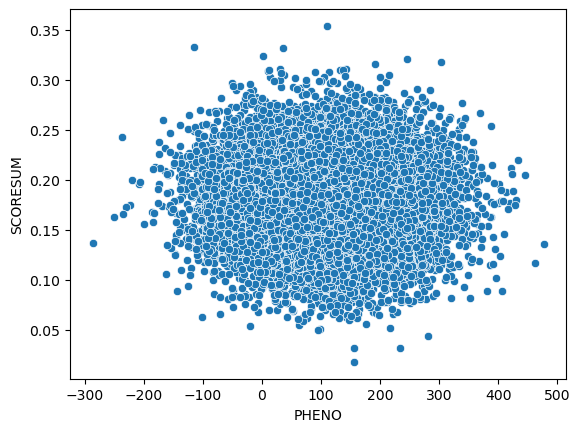

In [190]:
sns.scatterplot(data = tmp, x = "PHENO", y = "SCORESUM")

In [ ]:
22 rs12163450:49214863:G:A 49214863
22 rs17000153:49351316:C:T 49351316
22 rs17824774:49369993:C:A 49369993
22 rs4823969:49416063:C:T 49416063
22 rs135248:49527783:A:G 49527783
22 rs2688158:49618819:G:A 49618819
22 rs8138195:49739747:T:C 49739747
22 rs136773:49802450:A:G 49802450
22 rs137862:50446550:C:A 50446550
22 rs138270:50587979:T:G 50587979

In [27]:
tmp_score.sort_values("Score")

,Chr,ID,Position,Ref,Alt,Score
3378,22,rs8142414,26093187,G,T,-0.006896
3737,22,rs738401,26683328,G,A,-0.006848
9170,22,rs2017022,38213383,A,G,-0.006380
7524,22,rs5999338,34815224,T,C,-0.005274
3887,22,rs3747135,26879562,A,G,-0.004626
...,...,...,...,...,...,...
7629,22,rs16994510,35048291,G,A,0.003062
5833,22,rs5997740,31114345,C,A,0.003366
5282,22,rs3765303,29650774,C,T,0.003707
7403,22,rs9609962,34589494,G,A,0.003995


In [184]:
tmp_causal = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Causal/001/chr1_causal.txt", sep = " ", names = ["Chr", "ID", "Position"])

In [185]:
tmp_causal

,Chr,ID,Position
0,1,rs3748593,880390
1,1,rs9442373,1062638
2,1,rs11466691,1139862
3,1,rs12748433,1559971
4,1,rs6692648,1982397
...,...,...,...
1168,1,rs2799511,247400404
1169,1,rs12130716,247708542
1170,1,rs6695104,248060894
1171,1,rs28524986,248568202


In [40]:
tmp_score.sort_values("Score")["ID"]

3378      rs8142414
3737       rs738401
9170      rs2017022
7524      rs5999338
3887      rs3747135
            ...    
7629     rs16994510
5833      rs5997740
5282      rs3765303
7403      rs9609962
14265      rs762929
Name: ID, Length: 14955, dtype: object

In [186]:
inds = []
ss = []
for c in tmp_causal["ID"]:
    sl = list(tmp_score.sort_values("Score")["ID"])
    if c in sl:
        ind = sl.index(c)
        inds.append(ind)
        ss.append(list(tmp_score.sort_values("Score")["Score"])[ind])

In [90]:
[tt], [list(tmp_score.sort_values("Score")["Score"])[tt]]

([1670], [-0.0002216737])

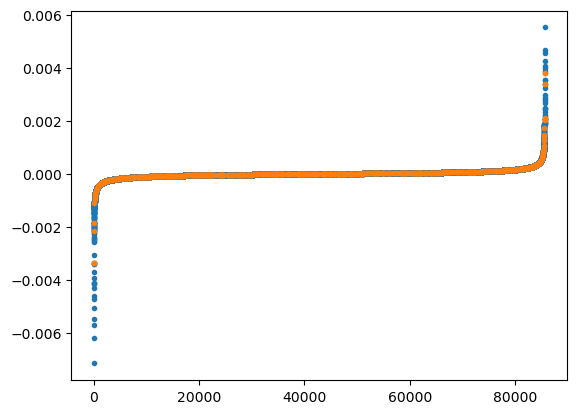

In [187]:
import matplotlib.pyplot as plt
plt.plot(list(tmp_score.sort_values("Score")["Score"]), ".")
plt.plot(inds, ss, ".")
# tt = list(tmp_score.sort_values("Score")["ID"]).index("rs9625188")
# plt.plot([tt], [list(tmp_score.sort_values("Score")["Score"])[tt]], color = "k")

In [95]:
eas_chr22_gwas = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Plink/GWAS/100k_20k_20k/Formatted/EAS_chr22.discovery.formatted.assoc.linear", sep = "\t")

In [131]:
top = eas_chr22_gwas.dropna().sort_values("P")["SNP"][:5000].tolist()

In [132]:
count = 0
for i in top:
    if i in tmp_causal["ID"].tolist():
        # print(i)
        count += 1
count

65

In [122]:
# eas_chr22_gwas[eas_chr22_gwas["SNP"] == "rs11090296"]
tmp_causal

,Chr,ID,Position
0,22,rs5747004,17614011
1,22,rs1125471,17656724
2,22,rs7288834,17832142
3,22,rs1296820,18077720
4,22,rs725768,18210409
...,...,...,...
174,22,rs2688158,49618819
175,22,rs8138195,49739747
176,22,rs136773,49802450
177,22,rs137862,50446550


,SNP,A1,A2,BETA,P
0,rs4911642,C,T,-0.9319,0.3849
1,rs131560,C,G,2.4220,0.4796
2,rs7287144,G,A,0.1500,0.8815
3,rs5748616,G,C,0.8665,0.3163
4,rs5748662,A,G,-0.4765,0.6335
...,...,...,...,...,...
19017,rs13056621,A,G,-1.2480,0.1702
19019,rs5771007,C,T,0.4692,0.8617
19020,rs3888396,C,T,-0.2827,0.7593
19021,rs2238837,C,A,1.0490,0.2333


In [150]:
from scipy import stats
# from sklearn.preprocessing import normalize

In [139]:
genotype_EAS.T[0].shape, EAS_pop.shape

((100000,), (100000,))

In [170]:
betas = []
es = []
ste = []
ps = []
for i in range(len(genotype_EAS.T)):
    try:
        gradient, _, _, p, std_err = stats.linregress(genotype_EAS.T[i], EAS_pop)
        betas.append(gradient)
        es.append(simulated_effect_sizes[:, 1][i])
        ste.append(std_err)
        ps.append(p)
    except:
        continue


In [171]:
def standardize(lst):
    mean = sum(lst) / len(lst)
    std = (sum((x - mean) ** 2 for x in lst) / len(lst)) ** 0.5
    return [(x - mean) / std for x in lst]

In [172]:
aa = standardize(es)

In [173]:
bb = standardize(betas)

# Making plots

In [7]:
import os
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [8]:

# pop = "EUR"
score_map = {"EAS_EAS":"", "EUR_EUR":"", "AFR_AFR":"", "EUR_EAS":"", "EUR_AFR":"", "EUR-EAS_EAS":"", "EUR-AFR_AFR":"", "EAS_EUR":"", "AFR_EUR":"", 
             "EUR-AFR_EUR":"", "EUR-EAS_EUR":""}
for mode in score_map:
    ii = 0
    print(mode)
    for i in range(22):
        chr = i + 1
        # print(chr)
        if mode in ["EUR_EUR", "EAS_EAS", "AFR_AFR"]:
            pop = mode.split("_")[0]
            prefix = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Plink/Scores/"
            f = pop + "_chr" + str(chr) + "_score.profile"
        elif mode in ["EUR_EAS", "EUR_AFR", "EAS_EUR", "AFR_EUR"]:
            pop = mode.split("_")[1]
            dis = mode.split("_")[0]
            prefix = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Plink/Scores/"
            f = pop + "_chr" + str(chr) + "_" + dis + "_discovery_score.profile"
        else:
            pop = mode.split("_")[1]
            dis = mode.split("_")[0]
            prefix = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Plink/Scores/Mix/"
            f_eur = pop + "_chr" + str(chr) + "_" + dis + "_EUR_discovery_score.profile"
            if pop == "EUR":
                f = pop + "_chr" + str(chr) + "_" + dis + "_" + dis.split("-")[1] + "_discovery_score.profile"
            else:
                f = pop + "_chr" + str(chr) + "_" + dis + "_" + pop + "_discovery_score.profile"
        if ii == 0:
            all_score = pd.read_csv(prefix + f, delim_whitespace=True)
            if mode in ["EUR-EAS_EAS", "EUR-AFR_AFR", "EUR-AFR_EUR", "EUR-EAS_EUR"]:
                tmp = pd.read_csv(prefix + f_eur, delim_whitespace=True)
                all_score["SCORE_EUR"] = tmp["SCORESUM"]
            ii += 1
            continue
        else:
            tmp_score = pd.read_csv(prefix + f, delim_whitespace=True)
            if mode in ["EUR-EAS_EAS", "EUR-AFR_AFR", "EUR-AFR_EUR", "EUR-EAS_EUR"]:
                tmp = pd.read_csv(prefix + f_eur, delim_whitespace=True)
                tmp_score["SCORE_EUR"] = tmp["SCORESUM"]
                all_score["SCORE_EUR"] = all_score["SCORE_EUR"] + tmp_score["SCORE_EUR"]
        all_score["SCORESUM"] = all_score["SCORESUM"] + tmp_score["SCORESUM"]
        
        ii += 1
    # if mode in ["EUR", "EAS", "AFR"]:
    #     score_map[mode + "_" + mode] = all_score
    # else:
    score_map[mode] = all_score

EAS_EAS
EUR_EUR
AFR_AFR
EUR_EAS
EUR_AFR
EUR-EAS_EAS
EUR-AFR_AFR
EAS_EUR
AFR_EUR
EUR-AFR_EUR
EUR-EAS_EUR


In [27]:
corr_map

{'EAS_EAS': [-0.23501121030192715],
 'EUR_EUR': [-0.4624585399062409],
 'AFR_AFR': [-0.20112669459846613],
 'EUR_EAS': [-0.28423432766354245],
 'EUR_AFR': [-0.24228249249813566],
 'EUR-EAS_EAS': [0.37594125975289794],
 'EUR-AFR_AFR': [0.32927354792301583],
 'EAS_EUR': [-0.1282640281672041],
 'AFR_EUR': [-0.11300126674014316],
 'EUR-AFR_EUR': [0.4688492313149309],
 'EUR-EAS_EUR': [0.4719171696726293]}

In [9]:
corr_map = {i:"" for i in score_map}
for i in score_map:
    if i not in ["EUR-EAS_EAS", "EUR-AFR_AFR", "EUR-AFR_EUR", "EUR-EAS_EUR"]:
        corr = np.corrcoef(score_map[i]["PHENO"], score_map[i]["SCORESUM"])[0, 1]
    else:
        X = score_map[i][['SCORESUM', 'SCORE_EUR']]  # Predictor variables
        y = score_map[i]['PHENO']     
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        pred_y = model.predict(X)
        corr = np.corrcoef(y, pred_y)[0, 1]
    corr_map[i] = [corr ** 2]

In [10]:
# calculate prscs-mult corr
for tp in ["AFR", "EAS"]:
    tmp = score_map[tp + "_" + tp]
    tmp["SCORE_EUR"] = score_map["EUR_" + tp]["SCORESUM"]
    X = tmp[['SCORESUM', 'SCORE_EUR']]  # Predictor variables
    y = tmp['PHENO']     
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    pred_y = model.predict(X)
    corr = np.corrcoef(y, pred_y)[0, 1]
    corr_map["EUR|" + tp + "_" + tp] = [corr ** 2]
for tp in ["AFR", "EAS"]:
    tmp = score_map["EUR_EUR"]
    tmp["SCORE_" + tp] = score_map[tp + "_EUR"]["SCORESUM"]
    X = tmp[['SCORESUM', 'SCORE_' + tp]]  # Predictor variables
    y = tmp['PHENO']     
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    pred_y = model.predict(X)
    corr = np.corrcoef(y, pred_y)[0, 1]
    corr_map["EUR|" + tp + "_EUR"] = [corr ** 2]

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


N_sizes = {
    'EAS': 'N = 20,000',
    'AFR': 'N = 20,000',
    'EUR': 'N = 100,000',
    'EUR+EAS': 'N = 120,000',
    'EUR+AFR': 'N = 120,000'
}

# Convert to DataFrame and preprocess
df_data = pd.DataFrame(list(corr_map.items()), columns=['Group', 'R2'])
df_data['R2'] = df_data['R2'].apply(lambda x: abs(x[0]) if isinstance(x, list) else abs(x))  # Assuming each list has at least one element

# Extract Discovery, Target, and Method from the Group column
def extract_info(group):
    parts = group.split('_')
    if "-" in parts[0]:
        discovery, target = parts
        discovery = discovery.replace('-', '+')
        method = 'PRS-CSx'
    elif "|" in parts[0]:
        discovery, target = parts
        discovery = discovery.replace('|', '+')
        method = 'PRS-CS-mult'
    else:
        discovery, target = parts
        method = 'PRS-CS'
    discovery = discovery + "\n" + N_sizes[discovery]
    return discovery, target, method

# Apply the extraction function to the Group column
df_data[['Discovery', 'Target', 'Method']] = df_data.apply(lambda x: extract_info(x['Group']), axis=1, result_type='expand')

df_data = df_data.sort_values("Method")


In [15]:
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


In [163]:
subset_eur.sort_values("Discovery")

,Group,R2,Discovery,Target,Method
7,EAS_EUR,0.128264,"EAS\nN = 20,000",EUR,PRS-CS
1,EUR_EUR,0.462459,"EUR\nN = 100,000",EUR,PRS-CS
14,EUR|EAS_EUR,0.465988,"EUR+EAS\nN = 120,000",EUR,PRS-CS-mult
10,EUR-EAS_EUR,0.471917,"EUR+EAS\nN = 120,000",EUR,PRS-CSx


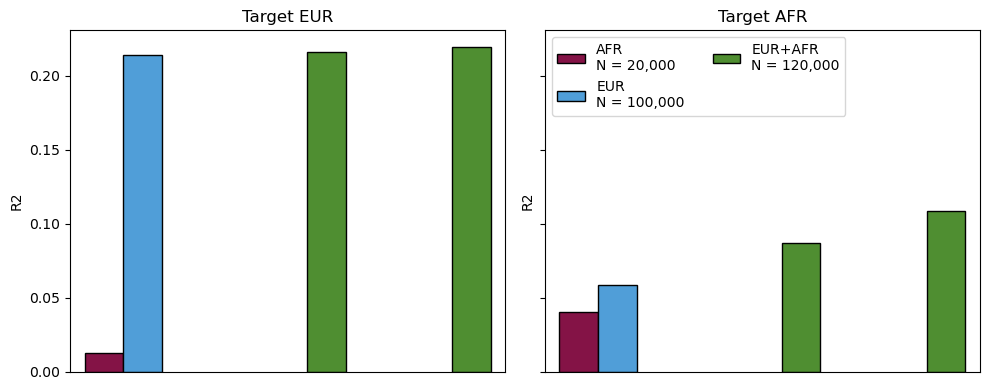

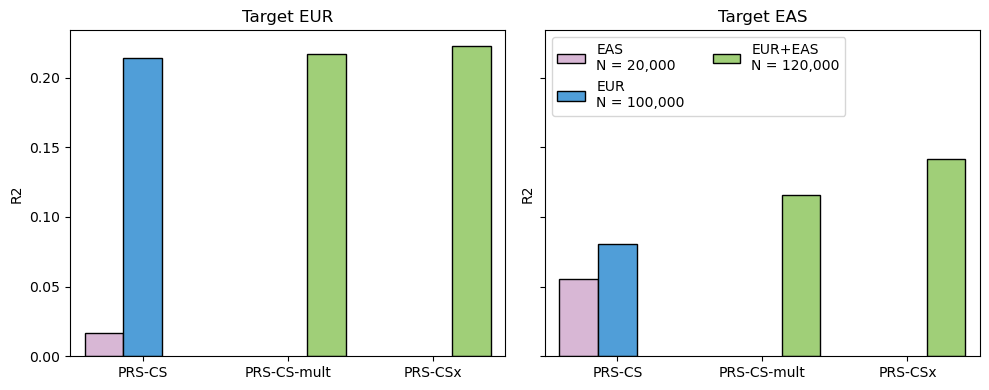

In [16]:
import warnings
warnings.filterwarnings('ignore')
colors = {
    'EAS\nN = 20,000': rgb_to_hex(221, 178, 217),
    'AFR\nN = 20,000': rgb_to_hex(151, 0, 68),
    'EUR\nN = 100,000': rgb_to_hex(57, 162, 239),
    'EUR+EAS\nN = 120,000': rgb_to_hex(159, 222, 105),
    'EUR+AFR\nN = 120,000': rgb_to_hex(74, 157, 34)
}
alt = {"AFR": "EAS", "EAS": "AFR"}
for i in ["AFR", "EAS"]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey = True)
    subset_eur = df_data[(df_data["Target"] == "EUR") & (~df_data["Discovery"].str.contains(alt[i]))]
    subset_eur = subset_eur.sort_values("Discovery")
    sns.barplot(data=subset_eur, x='Method', y='R2', hue='Discovery',
                palette=colors, errorbar=None, ax = ax1, edgecolor='black', linewidth=1)
    ax1.set_title("Target EUR")
    # plt.legend(ncol=2)
    ax1.get_legend().remove()
    ax1.set_xlabel("")
    if i == "AFR":
        ax1.set_xticks([])
    subset_i = df_data[(df_data["Target"] == i)]
    sns.barplot(data=subset_i, x='Method', y='R2', hue='Discovery',
                palette=colors, errorbar=None, ax = ax2, edgecolor='black', linewidth=1)
    ax2.set_title("Target " + i)
    ax2.set_xlabel("")
    if i == "AFR":
        ax2.set_xticks([])
    ax2.legend(ncol=2)
    plt.tight_layout()
    # if i == "AFR":
        # plt.savefig("/pollard/home/yorkz/york/BMI206/plot0.pdf")
warnings.filterwarnings('default')
# plt.savefig("/pollard/home/yorkz/york/BMI206/plot.pdf")

In [5]:
path = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Plink/Scores/Sensitivity/"
pops = ["AFR", "EAS", "EUR"]
sens_map = {}
for pop in pops:
    for h in ["0.05", "0.005"]:
        cc = 0
        for i in range(22):
            chr = i + 1
            file = pop + "_chr" + str(chr) + "_pheno_h" + h + "_score.profile"
            tmp = pd.read_csv(path + file, delim_whitespace=True)
            if cc == 0:
                current_df = tmp.copy()
            current_df["SCORESUM"] += tmp["SCORESUM"]
            cc += 1
        sens_map[pop + "_" + pop + "_h" + h] = current_df
    for c in ["0.1", "0.4"]:
        cc = 0
        for i in range(22):
            chr = i + 1
            file = pop + "_chr" + str(chr) + "_pheno_c" + c + "_score.profile"
            tmp = pd.read_csv(path + file, delim_whitespace=True)
            if cc == 0:
                current_df = tmp.copy()
            current_df["SCORESUM"] += tmp["SCORESUM"]
            cc += 1
        sens_map[pop + "_" + pop + "_c" + c] = current_df
        

In [6]:
corr_map_sens = {}
for i in sens_map:
    tmp = sens_map[i]
    corr = np.corrcoef(tmp["PHENO"], tmp["SCORESUM"])[0, 1]
    corr_map_sens[i] = [abs(corr)]

In [7]:
for i in corr_map:
    if i in ['EAS_EAS', 'EUR_EUR', 'AFR_AFR']:
        corr_map_sens[i + "_h0.5"] = [abs(corr_map[i][0])]
        corr_map_sens[i + "_c0.7"] = [abs(corr_map[i][0])]
corr_map_sens

{'AFR_AFR_h0.05': [0.023384837320693873],
 'AFR_AFR_h0.005': [0.005282707289335808],
 'AFR_AFR_c0.1': [0.1924006830859293],
 'AFR_AFR_c0.4': [0.20056947122492563],
 'EAS_EAS_h0.05': [0.03398430713127456],
 'EAS_EAS_h0.005': [0.01443408197202561],
 'EAS_EAS_c0.1': [0.25095865227255076],
 'EAS_EAS_c0.4': [0.24198523191109444],
 'EUR_EUR_h0.05': [0.0455664200040643],
 'EUR_EUR_h0.005': [0.0009667173502493411],
 'EUR_EUR_c0.1': [0.4570016489835335],
 'EUR_EUR_c0.4': [0.4573605082496888],
 'EAS_EAS_h0.5': [0.23501121030192715],
 'EAS_EAS_c0.7': [0.23501121030192715],
 'EUR_EUR_h0.5': [0.4624585399062409],
 'EUR_EUR_c0.7': [0.4624585399062409],
 'AFR_AFR_h0.5': [0.20112669459846613],
 'AFR_AFR_c0.7': [0.20112669459846613]}

In [47]:
correlation_df = 

,Population,Trait,Type,Value,R2
2,AFR,AFR,c,0.1,0.192401
3,AFR,AFR,c,0.4,0.200569
6,EAS,EAS,c,0.1,0.250959
7,EAS,EAS,c,0.4,0.241985
10,EUR,EUR,c,0.1,0.457002
11,EUR,EUR,c,0.4,0.457361
13,EAS,EAS,c,0.7,0.235011
15,EUR,EUR,c,0.7,0.462459
17,AFR,AFR,c,0.7,0.201127
18,EUR-AFR,AFR,c,0.1,0.176198


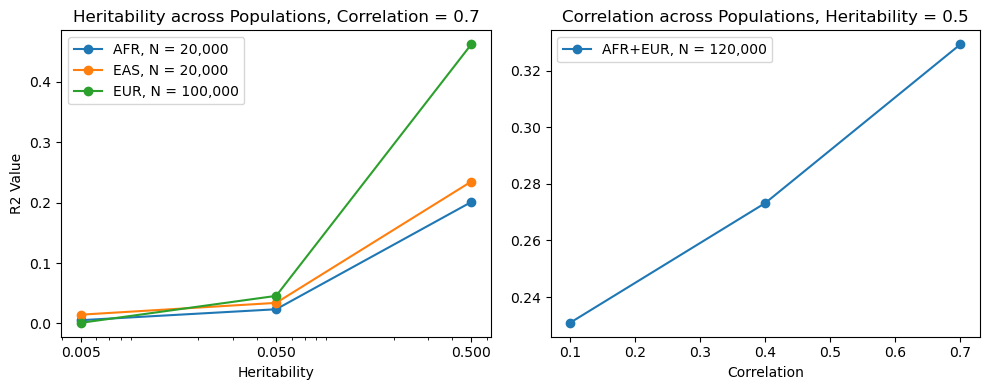

In [13]:
# Convert dictionary to DataFrame
data_items = []
for key, value in corr_map_sens.items():
    pop, trait, param = key.split('_')
    param_type, param_value = param[0], float(param[1:])
    data_items.append({'Population': pop, 'Trait': trait, 'Type': param_type, 'Value': param_value, 'R2': value[0]})
df = pd.DataFrame(data_items)

# Split into heritability and correlation DataFrames
heritability_df = df[df['Type'] == 'h'].copy()
correlation_df = df[df['Type'] == 'c'].copy()
correlation_df = correlation_df[correlation_df["Population"].str.contains("-")]

# Set up the Matplotlib subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot heritability
for pop in heritability_df['Population'].unique():
    subset = heritability_df[heritability_df['Population'] == pop]
    subset = subset.sort_values("Value", ascending = True)
    ax1.plot(subset['Value'], subset['R2'], marker='o', label=pop)

# Set x-axis to log scale
ax1.set_xscale('log')
ax1.set_xticks([0.005, 0.05, 0.5], ["0.005", "0.05", "0.5"])
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax1.set_xlabel('Heritability')
ax1.set_ylabel('R2 Value')
ax1.set_title('Heritability across Populations, Correlation = 0.7')
ax1.legend(["AFR, N = 20,000", "EAS, N = 20,000", "EUR, N = 100,000"])

# Plot correlation
for pop in correlation_df['Population'].unique():
    subset = correlation_df[correlation_df['Population'] == pop]
    subset = subset.sort_values("Value", ascending = True)
    ax2.plot(subset['Value'], subset['R2'], marker='o', label=pop)

ax2.set_xlabel('Correlation')
ax2.set_title('Correlation across Populations, Heritability = 0.5')
ax2.legend(["AFR+EUR, N = 120,000"])

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
path = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Plink/Scores/Sensitivity/"
pops = ["AFR"]
sens_map = {}
for pop in pops:
    # for h in ["0.05", "0.005"]:
    #     cc = 0
    #     for i in range(22):
    #         chr = i + 1
    #         file = pop + "_chr" + str(chr) + "_pheno_h" + h + "_score.profile"
    #         tmp = pd.read_csv(path + file, delim_whitespace=True)
    #         if cc == 0:
    #             current_df = tmp.copy()
    #         current_df["SCORESUM"] += tmp["SCORESUM"]
    #         cc += 1
    #     sens_map[pop + "_" + pop + "_h" + h] = current_df
    for c in ["0.1", "0.4"]:
        cc = 0
        for i in range(22):
            chr = i + 1
            file1 = pop + "_chr" + str(chr) + "_EUR-AFR_discovery_pheno_c" + c + "_EUR_score.profile"
            file2 = pop + "_chr" + str(chr) + "_EUR-AFR_discovery_pheno_c" + c + "_" + pop + "_score.profile"
            tmp1 = pd.read_csv(path + file1, delim_whitespace=True)
            tmp2 = pd.read_csv(path + file2, delim_whitespace=True)
            if cc == 0:
                current_df = tmp1.copy()
                current_df["SCORESUM2"] = tmp2["SCORESUM"]
            current_df["SCORESUM"] += tmp1["SCORESUM"]
            current_df["SCORESUM2"] += tmp2["SCORESUM"]
            cc += 1
        sens_map["EUR-" + pop + "_" + pop + "_c" + c] = current_df
        

In [37]:
sens_map

{'AFR_AFR_h0.05':              FID        IID     PHENO     CNT   CNT2  SCORESUM
 0          id1_1      id2_1 -279.1130  193656  70659  0.183230
 1          id1_3      id2_3 -695.4240  193656  70791 -0.015488
 2          id1_8      id2_8 -507.2590  193656  70655  0.205746
 3         id1_16     id2_16  250.8930  193656  70943  0.165778
 4         id1_26     id2_26  278.9410  193656  70778 -0.063114
 ...          ...        ...       ...     ...    ...       ...
 19995  id1_99984  id2_99984   48.7195  193656  70060  0.342782
 19996  id1_99989  id2_99989  124.8830  193656  71030  0.338806
 19997  id1_99991  id2_99991  217.6080  193656  70947  0.229493
 19998  id1_99995  id2_99995  804.7750  193656  71093  0.325706
 19999  id1_99997  id2_99997 -377.4420  193656  70081  0.223260
 
 [20000 rows x 6 columns],
 'AFR_AFR_h0.005':              FID        IID      PHENO     CNT   CNT2  SCORESUM
 0          id1_1      id2_1 -1128.5200  193656  70659  0.187726
 1          id1_3      id2_3 -2389.210

In [10]:
# corr_map_sens = {}
for i in sens_map:
    tmp = sens_map[i]
    X = tmp[['SCORESUM', 'SCORESUM2']]  # Predictor variables
    y = tmp['PHENO']     
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    pred_y = model.predict(X)
    corr = np.corrcoef(y, pred_y)[0, 1]
    corr_map_sens[i] = [abs(corr)]

In [11]:
corr_map_sens["EUR-AFR_AFR_c0.7"] = [0.32927354792301583]

In [12]:
corr_map_sens

{'AFR_AFR_h0.05': [0.023384837320693873],
 'AFR_AFR_h0.005': [0.005282707289335808],
 'AFR_AFR_c0.1': [0.1924006830859293],
 'AFR_AFR_c0.4': [0.20056947122492563],
 'EAS_EAS_h0.05': [0.03398430713127456],
 'EAS_EAS_h0.005': [0.01443408197202561],
 'EAS_EAS_c0.1': [0.25095865227255076],
 'EAS_EAS_c0.4': [0.24198523191109444],
 'EUR_EUR_h0.05': [0.0455664200040643],
 'EUR_EUR_h0.005': [0.0009667173502493411],
 'EUR_EUR_c0.1': [0.4570016489835335],
 'EUR_EUR_c0.4': [0.4573605082496888],
 'EAS_EAS_h0.5': [0.23501121030192715],
 'EAS_EAS_c0.7': [0.23501121030192715],
 'EUR_EUR_h0.5': [0.4624585399062409],
 'EUR_EUR_c0.7': [0.4624585399062409],
 'AFR_AFR_h0.5': [0.20112669459846613],
 'AFR_AFR_c0.7': [0.20112669459846613],
 'EUR-AFR_AFR_c0.1': [0.2309051803078115],
 'EUR-AFR_AFR_c0.4': [0.2731996069976427],
 'EUR-AFR_AFR_c0.7': [0.32927354792301583]}

In [42]:
f = open("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Discovery_sub/EUR_150000.discovery.line_numbers.txt", "r")
lines = f.readlines()
a = [int(i[:-1]) for i in lines]

f = open("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Discovery_sub/EUR_45000.discovery.line_numbers.txt", "r")
lines = f.readlines()
b = [int(i[:-1]) for i in lines]

In [43]:
len(a), len(b)

(150000, 45000)

In [26]:
ii = 0
pop = "EUR"
size = 50000
eur_size = 145000
afr_size = 5000
pheno = 1
for i in range(22):
    chr = i + 1
    prefix_1 = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/S1/"
    prefix = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/S3/"
    f = pop + "_chr" + str(chr) + "_" + str(size) + "_pheno" + str(pheno) + "_score.profile"
    f1 = "EUR-AFR" + "_chr" + str(chr) + "_" + str(eur_size) + "_" + str(afr_size) + "_pheno" + str(pheno) + "_EUR_score.profile"
    f2 = "EUR-AFR" + "_chr" + str(chr) + "_" + str(eur_size) + "_" + str(afr_size) + "_pheno" + str(pheno) + "_AFR_score.profile"
    if ii == 0:
        all_score_1 = pd.read_csv(prefix_1 + f, delim_whitespace=True)
        all_score = pd.read_csv(prefix + f1, delim_whitespace=True)
        tmp = pd.read_csv(prefix + f2, delim_whitespace=True)
        all_score["SCORESUM2"] = tmp["SCORESUM"]
        ii += 1
        continue
    else:
        tmp_score_1 = pd.read_csv(prefix_1 + f, delim_whitespace=True)
        tmp_score = pd.read_csv(prefix + f1, delim_whitespace=True)
        tmp = pd.read_csv(prefix + f2, delim_whitespace=True)
        tmp_score["SCORESUM2"] = tmp["SCORESUM"]
    all_score_1["SCORESUM"] = all_score_1["SCORESUM"] + tmp_score_1["SCORESUM"]
    all_score["SCORESUM"] = all_score["SCORESUM"] + tmp_score["SCORESUM"]
    all_score["SCORESUM2"] = all_score["SCORESUM2"] + tmp_score["SCORESUM2"]
    
    ii += 1

In [52]:

X = all_score[['SCORESUM', 'SCORESUM2']]  # Predictor variables
y = all_score['PHENO']     
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
pred_y = model.predict(X)
np.corrcoef(y, pred_y)[0, 1]

0.2910668565544981

In [27]:
np.corrcoef(all_score_1["PHENO"], all_score_1["SCORESUM"])[0, 1]

-0.3643859523227871

In [1]:
1

1

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re

def extract_info_from_filename(filename, scenario):
    if scenario != 'S3':
        match = re.search(r'chr(\d+)_([\d]+)_pheno(\d+)', filename)
        size = int(match.group(2))
        pheno = int(match.group(3))
    else:
        match = re.search(r'chr(\d+)_([\d]+)_([\d]+)_pheno(\d+)', filename)
        size = int(match.group(2)) + int(match.group(3))  # Sum of EUR and AFR sizes
        pheno = int(match.group(4))
    chromosome = int(match.group(1))
    file_type = 'EUR_score' if 'EUR_score' in filename else 'AFR_score' if 'AFR_score' in filename else None
    return chromosome, size, pheno, file_type


def read_and_process_files(directory, scenario, filter_fids=None):
    data = []
    for file in os.listdir(directory):
        if ".profile" not in file:
            continue
        chromosome, size, pheno, file_type = extract_info_from_filename(file, scenario)
        df = pd.read_csv(os.path.join(directory, file), delim_whitespace=True)
        if filter_fids is not None and size != 10000:  # Filter based on FIDs from size 10000
            df = df[df['FID'].isin(filter_fids)]
        df['chromosome'] = chromosome
        df['size'] = size
        df['pheno'] = pheno
        df['file_type'] = file_type
        data.append(df)
    return pd.concat(data)

def process_s1_train(directory):
    # First, read the size 10000 file to get the list of FIDs
    size_10000_file = next((f for f in os.listdir(directory) if '_10000_' in f and '.profile' in f), None)
    if size_10000_file:
        size_10000_df = pd.read_csv(os.path.join(directory, size_10000_file), delim_whitespace=True)
        filter_fids = size_10000_df['FID'].unique()
    else:
        raise FileNotFoundError("Size 10000 file not found in the directory")

    # Now read and process the files, filtering by FIDs from the 10000 size
    return read_and_process_files(directory, 'S1', filter_fids=filter_fids)


def calculate_total_prs(df, scenario):
    if scenario != 'S3':
        df = df.groupby(['FID', 'size', 'pheno'], as_index=False).agg({'SCORESUM': 'sum', 'PHENO': 'first'})
    else:
        df = df.groupby(['FID', 'size', 'pheno', 'file_type'], as_index=False).agg({'SCORESUM': 'sum', 'PHENO': 'first'})
    df.rename(columns={'SCORESUM': 'total_PRS'}, inplace=True)
    return df

def compute_regression(df, scenario):
    results = {}
    for size in df['size'].unique():
        for pheno in df['pheno'].unique():
            subset = df[(df['size'] == size) & (df['pheno'] == pheno)]
            if scenario != 'S3':
                X = subset['total_PRS']
                X = sm.add_constant(X)
                y = subset['PHENO']
            else:
                prs_pivot = subset.pivot_table(index='FID', columns='file_type', values='total_PRS').reset_index()
                pheno_values = subset[['FID', 'PHENO']].drop_duplicates()
                merged_subset = prs_pivot.merge(pheno_values, on='FID')
                X = merged_subset[['EUR_score', 'AFR_score']]
                X = sm.add_constant(X)
                y = merged_subset['PHENO']
            model = sm.OLS(y, X).fit()
            pred_y = model.predict(X)
            corr = np.corrcoef(y, pred_y)[0, 1]
            results[(size, pheno)] = corr ** 2
    return results
    
# Read and process files for each scenario
directory = "/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/"

s1_df = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/s1.df")
s2_df = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/s2.df")
s3_df = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/s3.df")
s1_train_df = pd.read_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/s1_train_fix.df")
# s1_df = read_and_process_files(directory + "S1", 'S1')
# print(1)
# s2_df = read_and_process_files(directory + "S2", 'S2')
# print(2)
# s3_df = read_and_process_files(directory + "S3", 'S3')
# print(3)
# s1_train_df = read_and_process_files(directory + "S1/Train/", 'S1')
# print(4)
# s1_train_df = process_s1_train(directory + "S1/Train/")

# # Calculate total PRS
# s1_df = calculate_total_prs(s1_df, 'S1')
# s2_df = calculate_total_prs(s2_df, 'S2')
# s1_train_df = calculate_total_prs(s1_train_df, 'S1')
# s3_df = calculate_total_prs(s3_df, 'S3')

# # Compute regression
s1_results = compute_regression(s1_df, 'S1')
s2_results = compute_regression(s2_df, 'S2')
s1_train_results = compute_regression(s1_train_df, 'S1')
s3_results = compute_regression(s3_df, 'S3')


In [19]:
# s1_df.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/s1.df", index = False)
# s2_df.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/s2.df", index = False)
# s3_df.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/s3.df", index = False)
# s1_train_df.to_csv("/pollard/home/yorkz/york/BMI206/Simulated_pop/Split/Overfitting_test/Plink/Scores/s1_train_fix.df", index = False)

,FID,size,pheno,total_PRS,PHENO
0,id1_1,10000,0,0.175968,94.43350
1,id1_1,10000,1,-0.160620,51.28770
2,id1_1,10000,2,0.226426,13.60050
3,id1_1,10000,3,-0.685505,-26.27630
4,id1_1,10000,4,-0.680864,82.41780
...,...,...,...,...,...
999995,id1_9998,195000,15,-0.433827,-39.09400
999996,id1_9998,195000,16,-0.215523,236.95500
999997,id1_9998,195000,17,-0.976964,-1.08912
999998,id1_9998,195000,18,0.631211,49.17900


In [54]:
# Ns = [10000, 50000, 100000, 150000, 195000]
h = 0.5
M = 60000
N_values = [10000, 50000, 100000, 150000, 195000]

# Calculate y for each N
y_values = [(h*N)/(N + 2*M) for N in N_values]

# Output the results
for N, y in zip(N_values, y_values):
    print(f"For N = {N}, y = {y}")

For N = 10000, y = 0.038461538461538464
For N = 50000, y = 0.14705882352941177
For N = 100000, y = 0.22727272727272727
For N = 150000, y = 0.2777777777777778
For N = 195000, y = 0.30952380952380953


<Figure size 1000x600 with 0 Axes>

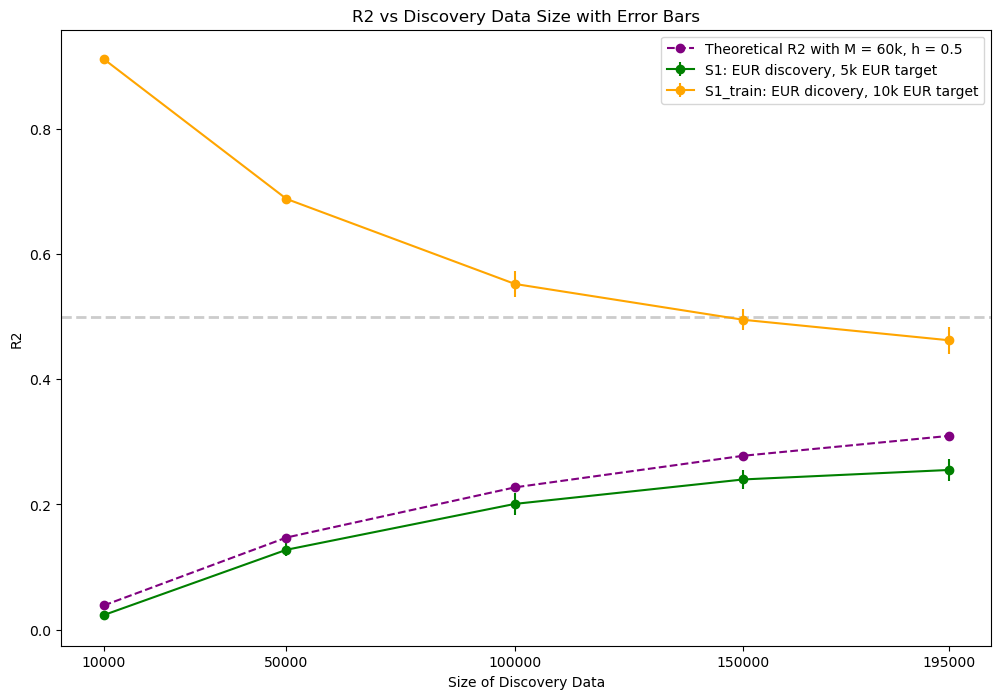

In [57]:
# # Plotting
# plt.figure(figsize=(10, 6))

# for size_pheno, coef in s1_results.items():
#     plt.scatter(size_pheno[0], coef, color='blue', label='S1' if size_pheno == list(s1_results.keys())[0] else "")

# for size_pheno, coef in s2_results.items():
#     plt.scatter(size_pheno[0], coef, color='red', label='S2' if size_pheno == list(s2_results.keys())[0] else "")

# for size_pheno, coef in s3_results.items():
#     plt.scatter(size_pheno[0], coef, color='green', label='S3' if size_pheno == list(s3_results.keys())[0] else "")

# plt.xlabel('Size of Training Data')
# plt.ylabel('R2')
# plt.title('Regression Coefficient vs Training Data Size')
# plt.legend()
# plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def plot_with_error_bars(results, color, label):
    sizes = sorted(set([size_pheno[0] for size_pheno in results.keys()]))
    means = []
    errors = []

    for size in sizes:
        coefficients = [coef for size_pheno, coef in results.items() if size_pheno[0] == size]
        mean = np.mean(coefficients)
        std = np.std(coefficients)
        means.append(mean)
        errors.append(std)

    plt.errorbar(sizes, means, yerr=errors, fmt='-o', color=color, label=label)

plt.figure(figsize=(10, 6))

def plot_with_error_bars_and_p_values(results_s1, results_s2, color_s1, color_s2):
    sizes = sorted(set([size_pheno[0] for size_pheno in results_s1.keys()]))

    means_s1 = []
    errors_s1 = []
    means_s2 = []
    errors_s2 = []
    p_values = []

    for size in sizes:
        coefficients_s1 = [coef for size_pheno, coef in results_s1.items() if size_pheno[0] == size]
        coefficients_s2 = [coef for size_pheno, coef in results_s2.items() if size_pheno[0] == size]

        mean_s1 = np.mean(coefficients_s1)
        std_s1 = np.std(coefficients_s1)
        mean_s2 = np.mean(coefficients_s2)
        std_s2 = np.std(coefficients_s2)

        means_s1.append(mean_s1)
        errors_s1.append(std_s1)
        means_s2.append(mean_s2)
        errors_s2.append(std_s2)

        # T-test
        t_stat, p_val = ttest_ind(coefficients_s1, coefficients_s2)
        p_values.append(p_val)

    # Plot S1
    plt.errorbar(sizes, means_s1, yerr=errors_s1, fmt='-o', color=color_s1, label='S2: EUR discovery, 5k AFR target')

    # Plot S2
    plt.errorbar(sizes, means_s2, yerr=errors_s2, fmt='-o', color=color_s2, label='S3: EUR + 5k AFR discovery, 5k AFR target')

    # Annotate p-values
    for i, p_val in enumerate(p_values):
        plt.annotate(f'p={p_val:.2e}', (sizes[i], max(means_s1[i], means_s2[i]) + max(errors_s1[i], errors_s2[i])), fontsize=12)

plt.figure(figsize=(12, 8))

# Plotting with T-test p-values
plot_with_error_bars(s1_results, 'green', 'S1: EUR discovery, 5k EUR target')
# plot_with_error_bars_and_p_values(s2_results, s3_results, 'red', 'blue')
plot_with_error_bars(s1_train_results, 'orange', 'S1_train: EUR dicovery, 10k EUR target')

# Plotting for each scenario

# plot_with_error_bars(s2_results, 'red', 'S2')
# plot_with_error_bars(s3_results, 'green', 'S3')
plt.plot(N_values, y_values, '--o', color='purple', label = "Theoretical R2 with M = 60k, h = 0.5")

plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=2, alpha = 0.4)
plt.xlabel('Size of Discovery Data')
plt.ylabel('R2')
plt.title('R2 vs Discovery Data Size with Error Bars')
plt.xticks([10000, 50000, 100000, 150000, 195000])
plt.legend()
# plt.xscale('log')
plt.show()


In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def fit_models(x, y):
    # Parabolic (Quadratic) Model
    x_quad = sm.add_constant(np.column_stack([x, x**2]))
    model_quad = sm.OLS(y, x_quad).fit()

    # Logarithmic Model
    x_log = sm.add_constant(np.log(x))
    model_log = sm.OLS(y, x_log).fit()

    # Inverse Model
    x_inv = sm.add_constant(1 / x)
    model_inv = sm.OLS(y, x_inv).fit()

    return model_quad, model_log, model_inv

def evaluate_models(models, x, y):
    names = ["Quadratic", "Logarithmic", "Inverse"]
    for i in range(len(models)):
        model = models[i]
        if i == 0:  # Quadratic model
            x_transformed = sm.add_constant(np.column_stack([x, x**2]))
        elif i == 1:  # Logarithmic model
            x_transformed = sm.add_constant(np.log(x))
        elif i == 2:  # Inverse model
            x_transformed = sm.add_constant(1 / x)
        else:  # Default (linear model)
            x_transformed = sm.add_constant(x)

        predictions = model.predict(x_transformed)
        rmse = np.sqrt(mean_squared_error(y, predictions))
        print(f"Model: {names[i]}, R-squared: {model.rsquared:.2f}, AIC: {model.aic:.2f}, BIC: {model.bic:.2f}, RMSE: {rmse:.2f}")

def calculate_sizes_and_means(results):
    size_to_coefficients = {}

    for (size, pheno), coef in results.items():
        if size not in size_to_coefficients:
            size_to_coefficients[size] = []
        size_to_coefficients[size].append(coef)

    sizes = []
    means = []

    for size, coefficients in size_to_coefficients.items():
        sizes.append(size)
        means.append(np.mean(coefficients))

    return np.array(sizes), np.array(means)

# Example usage with your data
# Assuming you have arrays 'sizes' as x and 'means' (from previous mean calculations) as y
sizes_s1, means_s1 = calculate_sizes_and_means(s1_results)
sizes_s2, means_s2 = calculate_sizes_and_means(s2_results)
sizes_s3, means_s3 = calculate_sizes_and_means(s3_results)
sizes_s1_train, means_s1_train = calculate_sizes_and_means(s1_train_results)


In [178]:
models_s1[2].model.exog_names

['const', 'x1']

In [12]:
print("S1")
models_s1 = fit_models(sizes_s1, means_s1)
evaluate_models(models_s1, sizes_s1, means_s1)
print("S2")
models_s2 = fit_models(sizes_s2, means_s2)
evaluate_models(models_s2, sizes_s2, means_s2)
print("S3")
models_s3 = fit_models(sizes_s3, means_s3)
evaluate_models(models_s3, sizes_s3, means_s3)
print("S1_train")
models_s1_train = fit_models(sizes_s1_train, means_s1_train)
evaluate_models(models_s1_train, sizes_s1_train, means_s1_train)

S1
Model: Quadratic, R-squared: 1.00, AIC: -33.31, BIC: -34.48, RMSE: 0.00
Model: Logarithmic, R-squared: 0.99, AIC: -28.95, BIC: -29.73, RMSE: 0.01
Model: Inverse, R-squared: 0.85, AIC: -15.83, BIC: -16.61, RMSE: 0.03
S2
Model: Quadratic, R-squared: 1.00, AIC: -61.94, BIC: -63.11, RMSE: 0.00
Model: Logarithmic, R-squared: 0.96, AIC: -32.87, BIC: -33.65, RMSE: 0.01
Model: Inverse, R-squared: 0.76, AIC: -24.26, BIC: -25.04, RMSE: 0.01
S3
Model: Quadratic, R-squared: 1.00, AIC: -68.70, BIC: -69.88, RMSE: 0.00
Model: Logarithmic, R-squared: 0.95, AIC: -32.27, BIC: -33.05, RMSE: 0.01
Model: Inverse, R-squared: 0.75, AIC: -23.86, BIC: -24.64, RMSE: 0.01
S1_train
Model: Quadratic, R-squared: 0.99, AIC: -21.06, BIC: -22.23, RMSE: 0.02
Model: Logarithmic, R-squared: 1.00, AIC: -27.63, BIC: -28.41, RMSE: 0.01
Model: Inverse, R-squared: 0.88, AIC: -10.67, BIC: -11.45, RMSE: 0.06


In [13]:
def fit_models_with_all_data(results):
    # Convert results to a DataFrame
    df = pd.DataFrame([(size_pheno[0], coef) for size_pheno, coef in results.items()], columns=['size', 'coefficient'])

    # Fit Quadratic, Logarithmic, and Inverse models
    x_quad = sm.add_constant(np.column_stack([df['size'], df['size']**2]))
    model_quad = sm.OLS(df['coefficient'], x_quad).fit()

    x_log = sm.add_constant(np.log(df['size']))
    model_log = sm.OLS(df['coefficient'], x_log).fit()

    x_inv = sm.add_constant(1 / df['size'])
    model_inv = sm.OLS(df['coefficient'], x_inv).fit()

    predictors = sm.add_constant(df['size'])
    model_glm_logit = sm.GLM(df['coefficient'], predictors, family=sm.families.Binomial()).fit()

    return model_quad, model_log, model_inv, model_glm_logit

# Example usage
models_s1 = fit_models_with_all_data(s1_results)
models_s2 = fit_models_with_all_data(s2_results)
models_s3 = fit_models_with_all_data(s3_results)
models_s1_train = fit_models_with_all_data(s1_train_results)
# Continue for S2 and S3

def evaluate_models(models, df):
    names = ["Quadratic", "Logarithmic", "Inverse", "Logit"]
    v = np.array([100000, 1000000])

    for i in range(len(models)):
        model = models[i]
        if i == 0:  # Quadratic model
            x_transformed = sm.add_constant(np.column_stack([df['size'], df['size']**2]))
            v_trans = sm.add_constant(np.column_stack([v, v ** 2]))
        elif i == 1:  # Logarithmic model
            x_transformed = sm.add_constant(np.log(df['size']))
            v_trans = sm.add_constant(np.log(v))
        elif i == 2:  # Inverse model
            x_transformed = sm.add_constant(1 / df['size'])
            v_trans = sm.add_constant(1 / v)
        elif i == 3:
            x_transformed = sm.add_constant(df['size'])
            v_trans = sm.add_constant(v)
        
        predictions = model.predict(x_transformed)
        pred_v = model.predict(v_trans)
        rmse = np.sqrt(mean_squared_error(df['coefficient'], predictions))
        if i != 3:
            print(f"Model: {names[i]}, R-squared: {model.rsquared:.2f}, AIC: {model.aic:.2f}, BIC: {model.bic:.2f}, RMSE: {rmse:.2f}, Pred at 1M: {pred_v[1]:.2f}")
        else:
            print(f"Model: {names[i]}, AIC: {model.aic:.2f}, BIC: {model.bic:.2f}, RMSE: {rmse:.2f}, Pred at 1M: {pred_v[1]:.2f}")

# Example usage
print("S1")
df_s1 = pd.DataFrame([(size_pheno[0], coef) for size_pheno, coef in s1_results.items()], columns=['size', 'coefficient'])
evaluate_models(models_s1, df_s1)
print("S2")
df_s2 = pd.DataFrame([(size_pheno[0], coef) for size_pheno, coef in s2_results.items()], columns=['size', 'coefficient'])
evaluate_models(models_s2, df_s2)
print("S3")
df_s3 = pd.DataFrame([(size_pheno[0], coef) for size_pheno, coef in s3_results.items()], columns=['size', 'coefficient'])
evaluate_models(models_s3, df_s3)
print("S1_train")
df_s1_train = pd.DataFrame([(size_pheno[0], coef) for size_pheno, coef in s1_train_results.items()], columns=['size', 'coefficient'])
evaluate_models(models_s1_train, df_s1_train)
# Continue for S2 and S3


S1
Model: Quadratic, R-squared: 0.97, AIC: -555.41, BIC: -547.59, RMSE: 0.01, Pred at 1M: -4.86
Model: Logarithmic, R-squared: 0.96, AIC: -533.40, BIC: -528.19, RMSE: 0.02, Pred at 1M: 0.38
Model: Inverse, R-squared: 0.83, AIC: -376.71, BIC: -371.50, RMSE: 0.04, Pred at 1M: 0.23
Model: Logit, AIC: 64.14, BIC: -449.48, RMSE: 0.04, Pred at 1M: 1.00
S2
Model: Quadratic, R-squared: 0.97, AIC: -753.80, BIC: -745.98, RMSE: 0.01, Pred at 1M: -0.96
Model: Logarithmic, R-squared: 0.92, AIC: -674.78, BIC: -669.57, RMSE: 0.01, Pred at 1M: 0.12
Model: Inverse, R-squared: 0.73, AIC: -547.89, BIC: -542.68, RMSE: 0.02, Pred at 1M: 0.07
Model: Logit, AIC: 33.31, BIC: -450.76, RMSE: 0.01, Pred at 1M: 1.00
S3
Model: Quadratic, R-squared: 0.96, AIC: -737.13, BIC: -729.32, RMSE: 0.01, Pred at 1M: -0.89
Model: Logarithmic, R-squared: 0.92, AIC: -660.57, BIC: -655.36, RMSE: 0.01, Pred at 1M: 0.13
Model: Inverse, R-squared: 0.72, AIC: -538.67, BIC: -533.46, RMSE: 0.02, Pred at 1M: 0.08
Model: Logit, AIC: 36.

/pollard/home/yorkz/miniconda3/envs/prs/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/pollard/home/yorkz/miniconda3/envs/prs/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/pollard/home/yorkz/miniconda3/envs/prs/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/pollard/home/yorkz/miniconda3/envs/prs/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version.

For N = 10000, y = 0.038461538461538464
For N = 50000, y = 0.14705882352941177
For N = 100000, y = 0.22727272727272727
For N = 150000, y = 0.2777777777777778
For N = 195000, y = 0.30952380952380953


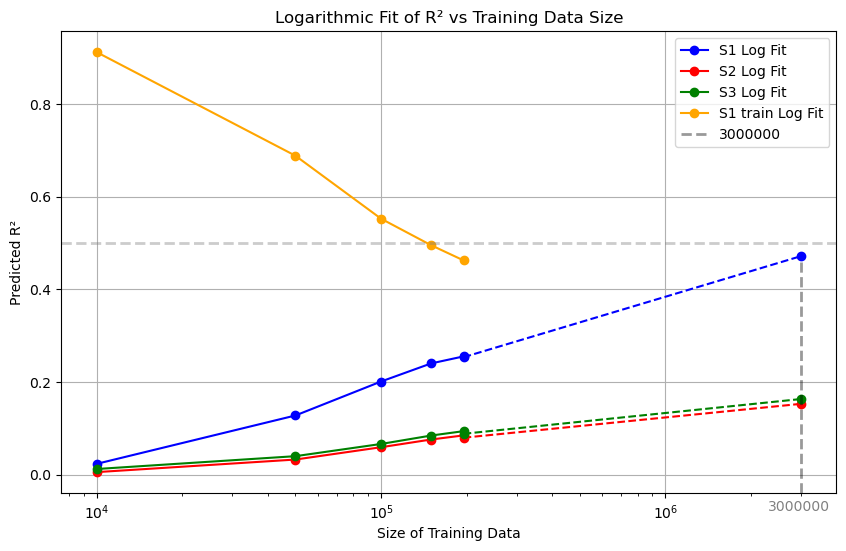

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def fit_log_model(sizes, values):
    # Fitting a logarithmic model requires taking the log of the sizes
    log_sizes = sm.add_constant(np.log(sizes))
    model = sm.OLS(values, log_sizes).fit()
    return model

def predict_log_model(model, new_sizes):
    # Predicting using a logarithmic model requires taking the log of the new sizes
    log_new_sizes = sm.add_constant(np.log(new_sizes))
    predictions = model.predict(log_new_sizes)
    return predictions

# Current sizes and their corresponding means for each scenario
current_sizes = np.array([10000, 50000, 100000, 150000, 195000])

# Fit the logarithmic model
model_s1 = fit_log_model(current_sizes, means_s1)
model_s2 = fit_log_model(current_sizes, means_s2)
model_s3 = fit_log_model(current_sizes, means_s3)
model_s1_train = fit_log_model(current_sizes, means_s1_train)

# Define the range for projection
projection_sizes = np.array([195000, 3000000])

# Get predictions for the projection
projection_predictions_s1 = predict_log_model(model_s1, projection_sizes)
projection_predictions_s2 = predict_log_model(model_s2, projection_sizes)
projection_predictions_s3 = predict_log_model(model_s3, projection_sizes)
projection_predictions_s1_train = predict_log_model(model_s1_train, projection_sizes)

# Plotting the logarithmic fitted lines for each scenario
plt.figure(figsize=(10, 6))

# Plot solid lines for actual observed values
plt.plot(current_sizes, means_s1, "-o", label='S1 Log Fit', color='blue')
plt.plot(current_sizes, means_s2, "-o", label='S2 Log Fit', color='red')
plt.plot(current_sizes, means_s3, "-o", label='S3 Log Fit', color='green')
plt.plot(current_sizes, means_s1_train, "-o", label='S1 train Log Fit', color='orange')

# Plot dashed lines for projected values
plt.plot(projection_sizes, projection_predictions_s1, '--o', color='blue')
plt.plot(projection_sizes, projection_predictions_s2, '--o', color='red')
plt.plot(projection_sizes, projection_predictions_s3, '--o', color='green')

# plt.plot(projection_sizes, projection_predictions_s1_train, '--o', color='orange')

# Additional plot settings
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=2, alpha = 0.4)
# plt.text(0, 0.5, '3000000', va='center', ha='right', color='gray')
plt.axvline(x=3000000, ymax = 0.5, color='k', linestyle='--', linewidth=2, alpha = 0.4, label = "3000000")
plt.text(3800000, -0.07, '3000000', va='center', ha='right', color='gray')
plt.xlabel('Size of Training Data')
plt.ylabel('Predicted R²')
plt.title('Logarithmic Fit of R² vs Training Data Size')
plt.legend()
plt.xscale('log')  # Logarithmic x-axis scale
plt.grid(True)
plt.show()

In [36]:
projection_predictions_s1

array([0.25331496, 0.47159323])

In [204]:
df_s1['size']

0      10000
1      10000
2      10000
3      10000
4      10000
       ...  
95    195000
96    195000
97    195000
98    195000
99    195000
Name: size, Length: 100, dtype: int64

In [ ]:
means_s1, means_s2, means_s3